In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [ ]:
churn_df = pd.read_csv("churn_data.csv")
trans_df = pd.read_csv("transactions.csv")
demo_df = pd.read_csv("demographics.csv")

In [ ]:
print("Churn Data Preview:")
print(churn_df.head(10))
print("\nTransactions Preview:")
print(trans_df.head(10))
print("\nDemographics Preview:")
print(demo_df.head(10))

Churn Data Preview:
  customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  CUST00000    Male              0     Yes        Yes      51           No   
1  CUST00001  Female              0      No        Yes       3          Yes   
2  CUST00002    Male              0     Yes        Yes      33           No   
3  CUST00003    Male              0      No        Yes      68          Yes   
4  CUST00004    Male              0     Yes        Yes      32           No   
5  CUST00005  Female              0      No        Yes      68           No   
6  CUST00006    Male              0      No         No      37           No   
7  CUST00007    Male              0     Yes         No      25           No   
8  CUST00008    Male              0      No        Yes       0          Yes   
9  CUST00009  Female              0     Yes        Yes       3           No   

  InternetService        Contract  MonthlyCharges  TotalCharges Churn  
0              No  Month-to-month     

In [ ]:
churn_df.drop_duplicates(inplace=True)
trans_df.drop_duplicates(inplace=True)
demo_df.drop_duplicates(inplace=True)

In [ ]:
churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')
churn_df['TotalCharges'].fillna(churn_df['TotalCharges'].median(), inplace=True)

<ipython-input-5-e8772ce80a80>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  churn_df['TotalCharges'].fillna(churn_df['TotalCharges'].median(), inplace=True)


In [ ]:
churn_df.replace(" ", np.nan, inplace=True)

In [ ]:
churn_df['TenureGroup'] = pd.cut(churn_df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12', '13-24', '25-48', '49-72'])

In [ ]:
agg_trans = trans_df.groupby('customerID').agg({
    'Amount': ['sum', 'mean', 'count']
})
agg_trans.columns = ['TotalSpent', 'AvgTransaction', 'TransactionCount']
agg_trans.reset_index(inplace=True)

In [ ]:
merged_df = churn_df.merge(agg_trans, on='customerID', how='left')
merged_df = merged_df.merge(demo_df, on='customerID', how='left')

In [ ]:
if 'TenureGroup' in merged_df.columns:
    merged_df['TenureGroup'] = merged_df['TenureGroup'].astype(str)

In [ ]:
for col in merged_df.columns:
    if merged_df[col].dtype == 'object':
        merged_df[col].fillna('Missing', inplace=True)
    else:
        merged_df[col].fillna(0, inplace=True)

<ipython-input-11-2a4f978031c3>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df[col].fillna('Missing', inplace=True)
<ipython-input-11-2a4f978031c3>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [ ]:
print("\nMerged Dataset Preview:")
print(merged_df.head(10))


Merged Dataset Preview:
  customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  CUST00000    Male              0     Yes        Yes      51           No   
1  CUST00001  Female              0      No        Yes       3          Yes   
2  CUST00002    Male              0     Yes        Yes      33           No   
3  CUST00003    Male              0      No        Yes      68          Yes   
4  CUST00004    Male              0     Yes        Yes      32           No   
5  CUST00005  Female              0      No        Yes      68           No   
6  CUST00006    Male              0      No         No      37           No   
7  CUST00007    Male              0     Yes         No      25           No   
8  CUST00008    Male              0      No        Yes       0          Yes   
9  CUST00009  Female              0     Yes        Yes       3           No   

  InternetService        Contract  MonthlyCharges  TotalCharges Churn  \
0              No  Month-to-mont

In [ ]:
label_cols = merged_df.select_dtypes(include='object').columns.drop(['customerID', 'Churn'])
le = LabelEncoder()
for col in label_cols:
    merged_df[col] = le.fit_transform(merged_df[col])


In [ ]:
merged_df['Churn'] = merged_df['Churn'].map({'Yes': 1, 'No': 0})

In [ ]:
features_to_scale = ['MonthlyCharges', 'TotalCharges', 'TotalSpent', 'AvgTransaction', 'Age']
scaler = StandardScaler()
merged_df[features_to_scale] = scaler.fit_transform(merged_df[features_to_scale])

In [ ]:
X = merged_df.drop(['customerID', 'Churn'], axis=1)
y = merged_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
lr = LogisticRegression(max_iter=1000)

In [ ]:
voting = VotingClassifier(estimators=[
    ('rf', rf), ('gb', gb), ('lr', lr)
], voting='soft')

models = {'Random Forest': rf, 'Gradient Boosting': gb, 'Voting Classifier': voting}


In [ ]:
eval_results = []


=== Random Forest ===
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86       453
           1       0.50      0.02      0.04       147

    accuracy                           0.76       600
   macro avg       0.63      0.51      0.45       600
weighted avg       0.69      0.76      0.66       600

Confusion Matrix:
 [[450   3]
 [144   3]]
Accuracy: 0.7550 | Precision: 0.5000 | Recall: 0.0204 | F1: 0.0392 | ROC AUC: 0.4986


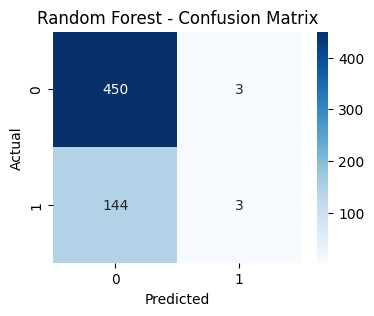


=== Gradient Boosting ===
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.98      0.86       453
           1       0.42      0.03      0.06       147

    accuracy                           0.75       600
   macro avg       0.59      0.51      0.46       600
weighted avg       0.67      0.75      0.66       600

Confusion Matrix:
 [[446   7]
 [142   5]]
Accuracy: 0.7517 | Precision: 0.4167 | Recall: 0.0340 | F1: 0.0629 | ROC AUC: 0.5379


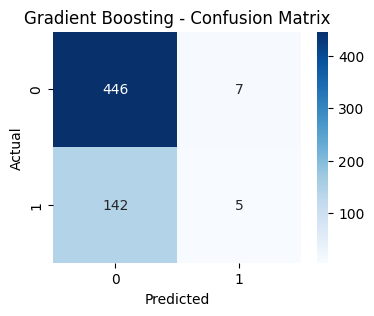


=== Voting Classifier ===
Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86       453
           1       0.33      0.01      0.01       147

    accuracy                           0.75       600
   macro avg       0.54      0.50      0.44       600
weighted avg       0.65      0.75      0.65       600

Confusion Matrix:
 [[451   2]
 [146   1]]
Accuracy: 0.7533 | Precision: 0.3333 | Recall: 0.0068 | F1: 0.0133 | ROC AUC: 0.5084


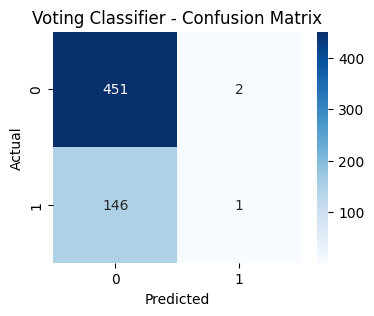

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n=== {name} ===")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC AUC: {roc:.4f}")

    eval_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc
    })

    # Optional: Visualize Confusion Matrix
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


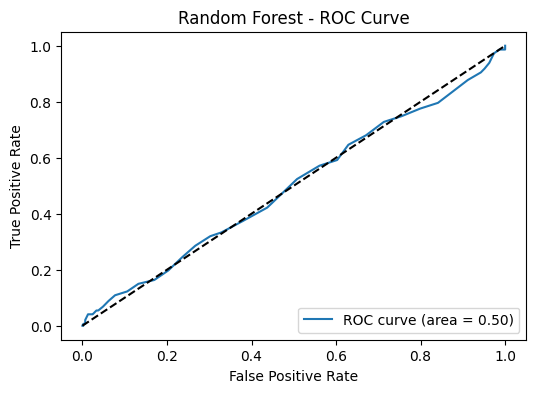

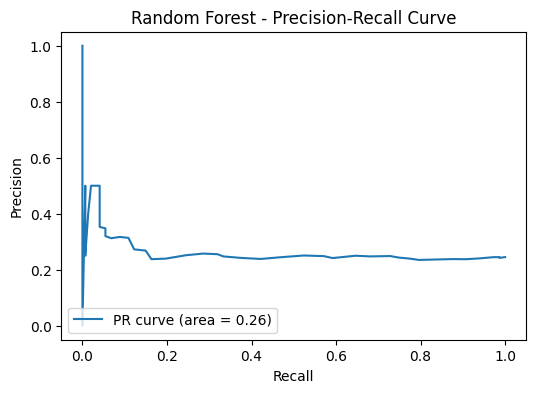

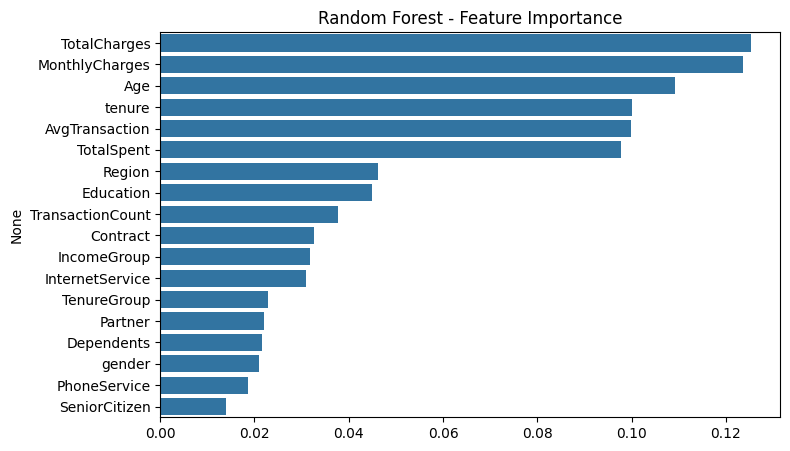

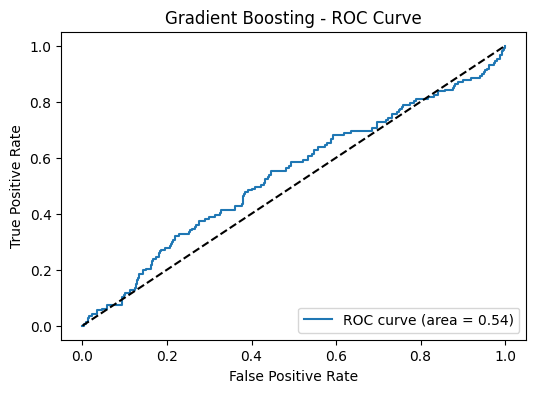

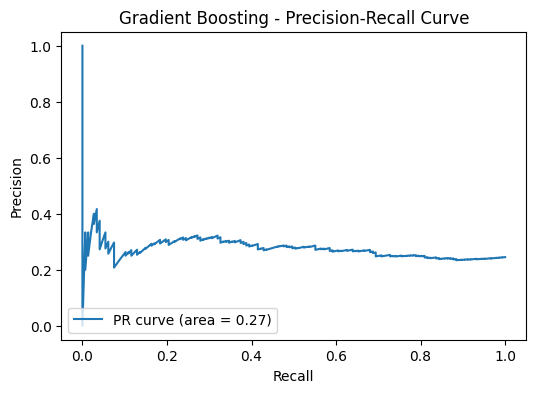

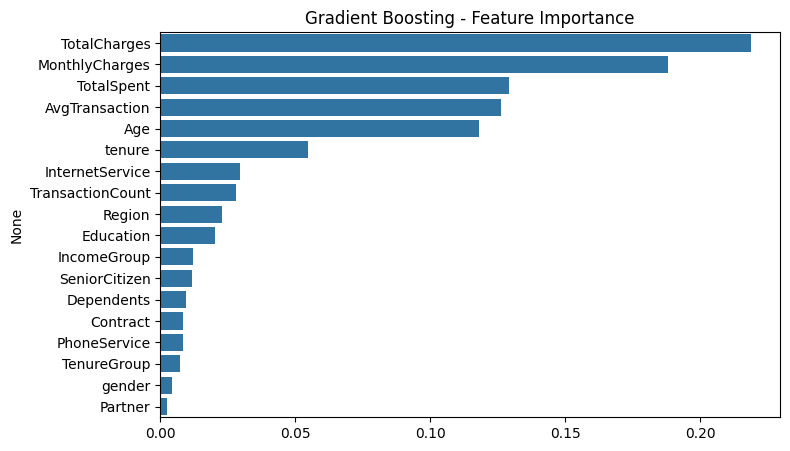

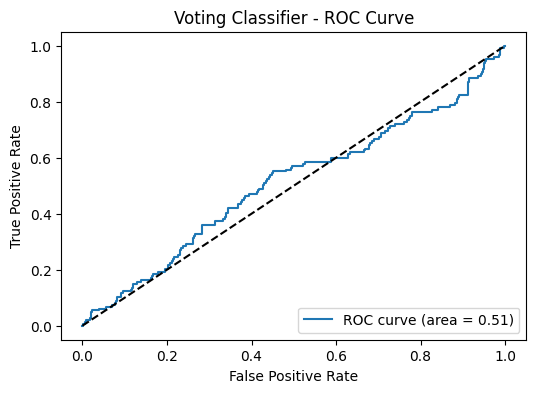

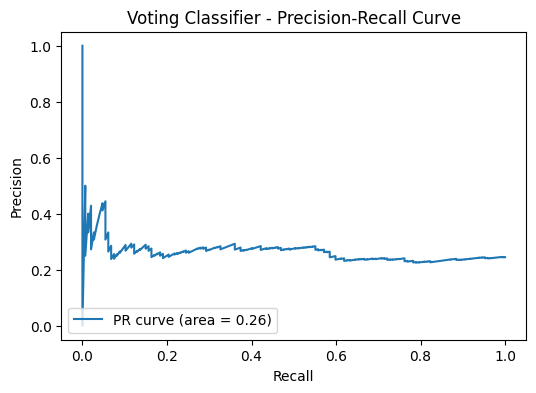

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

for name, model in models.items():
    # Predict probabilities for ROC and PR curves
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    y_pred = model.predict(X_test)

    if y_prob is not None:
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} - ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall, precision)

        plt.figure(figsize=(6,4))
        plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{name} - Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.show()

    # Feature Importance (only for RF and GB)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        feature_names = X.columns

        plt.figure(figsize=(8,5))
        sns.barplot(x=importances[indices], y=feature_names[indices])
        plt.title(f'{name} - Feature Importance')
        plt.show()


In [ ]:
eval_df = pd.DataFrame(eval_results)
print("\n=== Model Evaluation Summary ===")
print(eval_df)


=== Model Evaluation Summary ===
               Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0      Random Forest  0.755000   0.500000  0.020408  0.039216  0.498641
1      Random Forest  0.755000   0.500000  0.020408  0.039216  0.498641
2  Gradient Boosting  0.751667   0.416667  0.034014  0.062893  0.537896
3  Voting Classifier  0.753333   0.333333  0.006803  0.013333  0.508417


In [ ]:
merged_df.to_csv('churn_predictions_for_tableau.csv', index=False)
from google.colab import files
files.download('churn_predictions_for_tableau.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
eval_df.to_csv('model_metrics_tableau.csv', index=False)
files.download('model_metrics_tableau.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>